<a href="https://colab.research.google.com/github/VasanthSaravanann/MARL_DT/blob/main/Traditional_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpy pandas matplotlib seaborn


Manufacturing Process

In [2]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data log for KPI calculation
log_data = {
    'Product': [],
    'Process': [],
    'Start_Time': [],
    'End_Time': [],
    'Defective': []
}

# Process parameters (traditional, static)
PROCESS_TIMES = {'Heating': 2, 'Processing': 3, 'Cooling': 1}
DEFECT_PROB = 0.06  # 6% defect rate typical in traditional lines
DOWNTIME_PROB = 0.05  # 5% chance of breakdown per batch
DOWNTIME_DURATION = 2  # 2 time units per breakdown

def production_process(env, name, machines, log_data):
    # Heating
    with machines['Heater'].request() as request:
        yield request
        start = env.now
        yield env.timeout(PROCESS_TIMES['Heating'])
        end = env.now
        log_data['Product'].append(name)
        log_data['Process'].append('Heating')
        log_data['Start_Time'].append(start)
        log_data['End_Time'].append(end)
        log_data['Defective'].append(0)
    # Random breakdown
    if random.random() < DOWNTIME_PROB:
        yield env.timeout(DOWNTIME_DURATION)
    # Processing
    with machines['Processor'].request() as request:
        yield request
        start = env.now
        yield env.timeout(PROCESS_TIMES['Processing'])
        end = env.now
        log_data['Product'].append(name)
        log_data['Process'].append('Processing')
        log_data['Start_Time'].append(start)
        log_data['End_Time'].append(end)
        log_data['Defective'].append(0)
    # Cooling
    with machines['Cooler'].request() as request:
        yield request
        start = env.now
        yield env.timeout(PROCESS_TIMES['Cooling'])
        end = env.now
        # Quality check (manual, after cooling)
        defective = 1 if random.random() < DEFECT_PROB else 0
        log_data['Product'].append(name)
        log_data['Process'].append('Cooling')
        log_data['Start_Time'].append(start)
        log_data['End_Time'].append(end)
        log_data['Defective'].append(defective)

def product_generator(env, machines, log_data, num_products=50, arrival_interval=1):
    for i in range(num_products):
        yield env.timeout(arrival_interval)
        env.process(production_process(env, f'Product_{i+1}', machines, log_data))

# Set up the simulation environment
env = simpy.Environment()
machines = {
    'Heater': simpy.Resource(env, capacity=1),
    'Processor': simpy.Resource(env, capacity=1),
    'Cooler': simpy.Resource(env, capacity=1)
}
env.process(product_generator(env, machines, log_data, num_products=50, arrival_interval=1))
env.run()


Calculate Traditional Manufacturing KPIs

In [3]:
df = pd.DataFrame(log_data)

# Throughput: Total products completed
throughput = df['Product'].nunique()

# Cycle time: Average time from first to last process per product
cycle_times = []
for prod in df['Product'].unique():
    prod_df = df[df['Product'] == prod]
    cycle_times.append(prod_df['End_Time'].max() - prod_df['Start_Time'].min())
avg_cycle_time = sum(cycle_times) / len(cycle_times)

# Defect rate
num_defective = df[df['Defective'] == 1]['Product'].nunique()
defect_rate = num_defective / throughput

# Machine downtime (total time spent in breakdown)
total_downtime = DOWNTIME_DURATION * sum(
    1 for i in range(throughput) if random.random() < DOWNTIME_PROB
)

# OEE (simplified for demo)
availability = (env.now - total_downtime) / env.now
performance = throughput / (env.now / (sum(PROCESS_TIMES.values())))
quality = 1 - defect_rate
oee = availability * performance * quality

print(f"Traditional System KPIs:")
print(f"  Throughput: {throughput}")
print(f"  Avg Cycle Time: {avg_cycle_time:.2f}")
print(f"  Defect Rate: {defect_rate:.2%}")
print(f"  Availability: {availability:.2%}")
print(f"  Performance: {performance:.2f}")
print(f"  Quality: {quality:.2%}")
print(f"  OEE: {oee:.2%}")


Traditional System KPIs:
  Throughput: 50
  Avg Cycle Time: 30.50
  Defect Rate: 6.00%
  Availability: 97.40%
  Performance: 1.95
  Quality: 94.00%
  OEE: 178.36%


Visualize the Traditional System

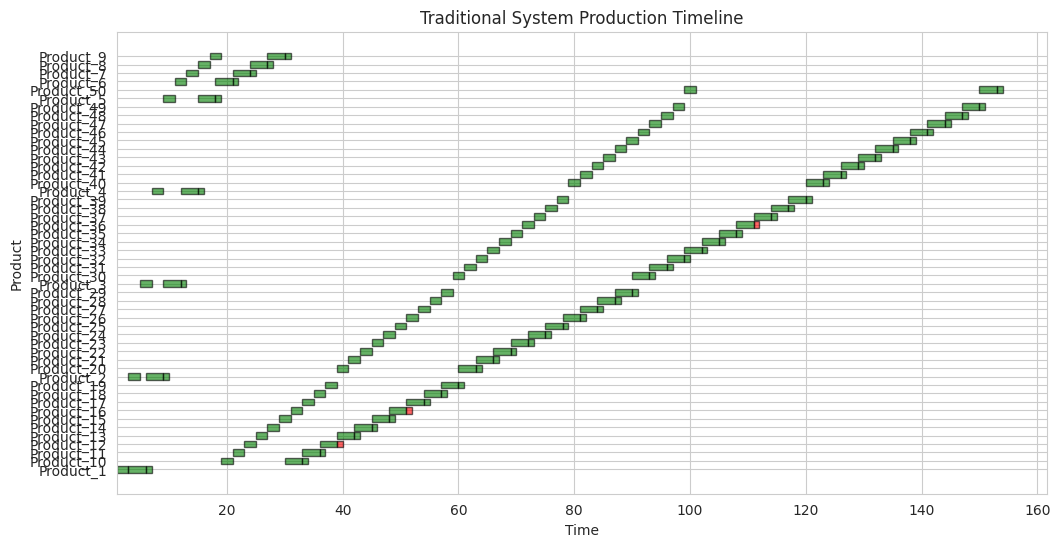

In [4]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
for product_name, product in df.groupby('Product'):
    for _, row in product.iterrows():
        plt.barh(
            y=row['Product'],
            width=row['End_Time'] - row['Start_Time'],
            left=row['Start_Time'],
            edgecolor='black',
            color='red' if row['Defective'] else 'green',
            alpha=0.6
        )
plt.xlabel('Time')
plt.ylabel('Product')
plt.title('Traditional System Production Timeline')
plt.show()
